In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 38.4 MB/s 
     |████████████████████████████████| 4.6 MB 33.0 MB/s 
     |████████████████████████████████| 3.2 MB 36.6 MB/s 
     |████████████████████████████████| 512 kB 29.4 MB/s 
     |████████████████████████████████| 280 kB 88.3 MB/s 


In [2]:
# Install our repo
# !git clone -b models "https://github.com/ab7289-tandon-nyu/GraphVision.git"
# !cp -r /content/GraphVision/src/ .

!pip install -q git+https://github.com/ab7289-tandon-nyu/GraphVision.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 121 kB 31.1 MB/s 
     |████████████████████████████████| 1.6 MB 66.8 MB/s 
     |████████████████████████████████| 83 kB 2.7 MB/s 


In [3]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
from src.transforms import get_transforms
from src.datasets import get_datasets, get_dataloaders

transforms = get_transforms("cartesian")
train_dataset, valid_dataset, test_dataset = get_datasets(".data/", 
                        "CIFAR10", pre_transforms = None,
                        transforms = transforms)
BATCH_SIZE = 256

train_loader, valid_loader, test_loader = get_dataloaders(train_dataset,
                                                          valid_dataset,
                                                          test_dataset,
                                                          batch_size=(BATCH_SIZE, 1, 1),
                                                          drop_last = False)

Extracting .data/CIFAR10/raw/CIFAR10_v2.zip
Processing...
Done!


## Review batch attributes

In [6]:
sample_batch = next(iter(train_loader))

print()
print(sample_batch)
print("=====================================================================")

# Gather some statistics about the first graph.
print(f"Number of features:  {sample_batch.num_features}")
print(f"Number of node features: {sample_batch.num_node_features}")
print(f'Number of nodes: {sample_batch.num_nodes}')
print(f'Number of edges: {sample_batch.num_edges}')
print(f'Average node degree: {sample_batch.num_edges / sample_batch.num_nodes:.2f}')
print(f'Has isolated nodes: {sample_batch.has_isolated_nodes()}')
print(f'Has self-loops: {sample_batch.has_self_loops()}')


DataBatch(x=[30065, 3], edge_index=[2, 270585], edge_attr=[270585, 2], y=[256], pos=[30065, 2], edge_weight=[270585], batch=[30065], ptr=[257])
Number of features:  3
Number of node features: 3
Number of nodes: 30065
Number of edges: 270585
Average node degree: 9.00
Has isolated nodes: False
Has self-loops: True


In [7]:
# store edge dimension
edge_dim = sample_batch.edge_attr.size(-1)
edge_dim
# store number of features in graph batch
input_features = test_dataset.num_features
# store number of classes for classification
num_classes = test_dataset.num_classes

print(f"Number of features: {input_features}")
print(f"Number of classes: {num_classes}")
print(f"Edge Attr Dimension: {edge_dim}")
print(f"Steps per epoch: {len(train_loader)}")

Number of features: 3
Number of classes: 10
Edge Attr Dimension: 2
Steps per epoch: 176


In [8]:
from pathlib import Path

save_loc = "/content/drive/MyDrive/saved_models/" # put save location here
model_name = "GeneralConv_clus-false_LN_GELU_layer64.pt"

file_path = save_loc + model_name
path = Path(file_path)
state_dict = None
if path.exists() and path.is_file():
  print("Found Save!")
  state_dict = torch.load(path)
else:
  print("Creating new Model")

Found Save!


## Create our Model

In [9]:
from src.models import DeeperGCN
from src.engine import evaluate

hidden_features = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeeperGCN(
    input_features,
    num_classes,
    hidden_features,
    conv_type = "General",
    act = "gelu",
    norm = "layer",
    num_layers = 64,
    use_cluster_pooling = False,
    readout = "mean",
    dropout = 0.2,
    edge_dim = edge_dim
).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
prev_loss = None
if state_dict is not None:
  print("Loading previously saved state dictionary")
  model.load_state_dict(state_dict)
  prev_loss, _ = evaluate(model.to(device), test_loader, criterion, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, verbose=True, cycle_momentum=False)

Loading previously saved state dictionary
Adjusting learning rate of group 0 to 1.0000e-04.


In [10]:
params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"There are {params:,} trainable parameters.")
print()
print(model)

There are 4,296,202 trainable parameters.

DeeperGCN(
  (fc_in): Linear(in_features=3, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (out_act): GELU(approximate='none')
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
    (3): DeepGCNLayer(block=res+)
    (4): DeepGCNLayer(block=res+)
    (5): DeepGCNLayer(block=res+)
    (6): DeepGCNLayer(block=res+)
    (7): DeepGCNLayer(block=res+)
    (8): DeepGCNLayer(block=res+)
    (9): DeepGCNLayer(block=res+)
    (10): DeepGCNLayer(block=res+)
    (11): DeepGCNLayer(block=res+)
    (12): DeepGCNLayer(block=res+)
    (13): DeepGCNLayer(block=res+)
    (14): DeepGCNLayer(block=res+)
    (15): DeepGCNLayer(block=res+)
    (16): DeepGCNLayer(block=res+)
    (17): DeepGCNLayer(block=res+)
    (18): DeepGCNLayer(block=res+)
    (19): DeepGCNLayer(block=res+)
    (20): DeepGCNLayer(block=res+)
    (21): DeepGCNLayer(block=res+

## Train

In [11]:
from src.engine import train, evaluate
from src.utils import calculate_accuracy

EPOCHS = 100-18-9
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
best_loss = float('inf')
best_loss = float('inf')
if prev_loss is not None:
  print(f"Training from previous best loss: {prev_loss}")
  best_loss = prev_loss

for epoch in range(1, EPOCHS + 1):
  print(f"\nEpoch: {epoch}\n")
  loss, acc = train(model, train_loader, criterion, optimizer, device)
  train_loss.append(loss)
  train_acc.append(acc)
  print(f"Train Loss: {train_loss[-1]:.3f}, Train Accuracy: {train_acc[-1]:.2f}")

  scheduler.step()

  loss, acc = evaluate(model, valid_loader, criterion, device)
  valid_loss.append(loss)
  valid_acc.append(acc)
  print(f"Validation Loss: {valid_loss[-1]:.3f}, Validation Accuracy: {valid_acc[-1]:.2f}")

  if loss < best_loss:
    best_loss = loss
    torch.save(model.state_dict(), path)

Training from previous best loss: 1.9494455734848977

Epoch: 1

Train Loss: 1.989, Train Accuracy: 0.24
Adjusting learning rate of group 0 to 1.0045e-04.
Validation Loss: 1.914, Validation Accuracy: 0.28

Epoch: 2

Train Loss: 1.976, Train Accuracy: 0.25
Adjusting learning rate of group 0 to 1.0090e-04.
Validation Loss: 1.914, Validation Accuracy: 0.27

Epoch: 3

Train Loss: 1.978, Train Accuracy: 0.25
Adjusting learning rate of group 0 to 1.0135e-04.
Validation Loss: 1.977, Validation Accuracy: 0.25

Epoch: 4

Train Loss: 1.969, Train Accuracy: 0.25
Adjusting learning rate of group 0 to 1.0180e-04.
Validation Loss: 1.881, Validation Accuracy: 0.29

Epoch: 5

Train Loss: 1.954, Train Accuracy: 0.26
Adjusting learning rate of group 0 to 1.0225e-04.
Validation Loss: 1.890, Validation Accuracy: 0.28

Epoch: 6

Train Loss: 1.951, Train Accuracy: 0.26
Adjusting learning rate of group 0 to 1.0270e-04.
Validation Loss: 1.898, Validation Accuracy: 0.29

Epoch: 7

Train Loss: 1.948, Train Accur

## Evaluate on the Test set

In [12]:
# load best model
model.load_state_dict(torch.load(path))
test_loss, test_acc = evaluate(model.to(device), test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.546
Test Accuracy: 0.44%


## Plot Loss and Accuracy Curves

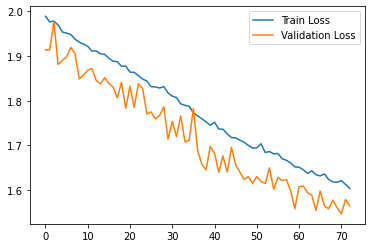

In [13]:
import matplotlib.pyplot as plt

x = [i for i in range(len(valid_loss))]

plt.plot(x, train_loss, label="Train Loss")
plt.plot(x, valid_loss, label="Validation Loss")
plt.legend()
plt.show()

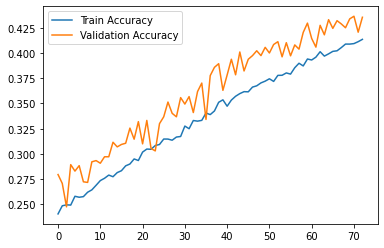

In [14]:
plt.plot(x, train_acc, label="Train Accuracy")
plt.plot(x, valid_acc, label="Validation Accuracy")
plt.legend()
plt.show()